# Experiment - Logistic Regression
We evaluate Adam optimizer on multi-class logistic regression with L2-regularization using the MNIST dataset.

### Optimizers Compared
1. Adam with learnig rate decay
2. SGD with Nesterov momentum
3. Adagrad

### HyperParameters
All Optimizers are trained with batchsize of 128.

Adam optimizer has The stepsize \\(\alpha\\). In the paper experiments, the learning rate is adjusted by \\(\alpha_{t}=\frac{1}{\sqrt{t}}\alpha\\), where t is the epoch number. In our experiment we adjusted it as well.

#### Hyper-parameter search
In the paper the hyper-parameters search was done by a dense grid search. We used optuna library for the search. The results are reported using the best hyper-parameter settings both in the paper and in our experiment.

### Weight Initialization
In the paper the models were initialized with the same weights.
In our experiment we did it as well, and also tried with random initialization for every optimizer.

#### Notes
The paper did not state the best parameter settings, nor the accuracy.

In [2]:
import torch
import torchvision.datasets as dset
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import optuna
import pickle

In [3]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

In [5]:
new_mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist'
datasets.MNIST.resources = [
   ('/'.join([new_mirror, url.split('/')[-1]]), md5)
   for url, md5 in datasets.MNIST.resources
]

train_dataset = datasets.MNIST(root=root, train=True, download=True, transform=transforms.Compose([
transforms.ToTensor()]))
test_dataset = dset.MNIST(root=root, train=False, download=True, transform=transforms.Compose([
transforms.ToTensor()]))

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!

C:\Users\Yosha\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
batch_size = 128
epochs = 45
input_dim = 784
output_dim = 10

In [7]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
num_of_sample=len(train_dataset)

### The Logistic Regression Model
Logistic Regression model is implemented with a sigle linear layer, and we get the logistic regression probabilities from the cross entropy loss function.

In [9]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.reshape(x.shape[0], input_dim)
        outputs = self.linear(x)
        return outputs.squeeze()

In [10]:
def score(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels = torch.tensor(labels, dtype=torch.long)
            images = torch.tensor(images, dtype=torch.float)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [11]:
def save_model_data(name, model, loss_arr, acc_arr, lr_arr):
    run_number = 0
    PATH = f'./logistic_models/{name}_{run_number}.pkl'
    while os.path.isfile(PATH):
        run_number += 1
        PATH = f'./logistic_models/{name}_{run_number}.pkl'
    torch.save(model.state_dict(), PATH)
    with open(f'logistic_models/{name}_loss.pkl', 'wb') as fp:
        pickle.dump(loss_arr, fp)
    with open(f'logistic_models/{name}_acc.pkl', 'wb') as fp:
        pickle.dump(acc_arr, fp)
    with open(f'logistic_models/{name}_lr.pkl', 'wb') as fp:
        pickle.dump(lr_arr, fp)
    print(loss_arr)

### Training Loop

In [12]:
def train(model, trainloader, optimizer, name, learning_rate_decay=False):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_path = f'./logistic_models/{name}_loss.pkl'
    acc_path = f'./logistic_models/{name}_acc.pkl'
    lr_path = f'./logistic_models/{name}_lr.pkl'
    loss_arr = []
    lr_arr = []
    acc_arr = []
    if os.path.isfile(loss_path) and os.path.getsize(loss_path) > 0:
        with open(loss_path, 'rb') as fp:
            loss_arr = pickle.load(fp)
        with open(acc_path, 'rb') as fp:
            acc_arr = pickle.load(fp)
        with open(lr_path, 'rb') as fp:
            lr_arr = pickle.load(fp)
    decay_factor = lambda x: 1/math.sqrt(len(loss_arr)+1) 
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=decay_factor)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            labels = torch.tensor(labels, dtype=torch.long)
            inputs = torch.tensor(inputs, dtype=torch.float)
            optimizer.zero_grad()
            outputs = model(inputs.type(torch.float))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        lr_arr.append(optimizer.param_groups[0]["lr"])
        if learning_rate_decay:
            scheduler.step()
        loss_arr.append(running_loss/num_of_sample)
        acc_arr.append(score(model, test_loader))
        print(f'epoch: {epoch}, loss: {running_loss/num_of_sample}, lr: {optimizer.param_groups[0]["lr"]}, acc: {acc_arr[-1]}')
    save_model_data(name, model, loss_arr, acc_arr, lr_arr)
    return loss_arr, lr_arr

# Parameter Search


In [13]:
def objective_adam_with_decay(trial):
    model_adam = LogisticRegression(input_dim, output_dim)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    beta_1 = trial.suggest_loguniform("beta_1", 0.6, 1)
    beta_2 = trial.suggest_loguniform("beta_2", 0.9, 1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1)
    optimizer = torch.optim.Adam(model_adam.parameters(), lr=lr, betas=(beta_1, beta_2), weight_decay=weight_decay)
    name = f'adam_decay_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'beta1_{optimizer.param_groups[0]["betas"][0]}_beta2_{optimizer.param_groups[0]["betas"][1]}_' +\
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss, lrs = train(model_adam, train_loader, optimizer, name, learning_rate_decay=True)
    return score(model_adam, test_loader)

def objective_adagrad(trial):
    model_adagrad = LogisticRegression(input_dim, output_dim)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1)
    optimizer = torch.optim.Adagrad(model_adagrad.parameters(), lr=lr, weight_decay=weight_decay)
    name = f'adagrad_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss, lrs = train(model_adagrad, train_loader, optimizer, name, learning_rate_decay=False)
    return score(model_adagrad, test_loader)

def objective_sgd_nst(trial):
    model_sgd_nst = LogisticRegression(input_dim, output_dim)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    momentum = trial.suggest_loguniform("momentum", 1e-8, 1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1)
    optimizer = torch.optim.SGD(model_sgd_nst.parameters(), nesterov=True, 
                             momentum=momentum, lr=lr, weight_decay=weight_decay)
    name = f'sgd_nst_lr_{optimizer.param_groups[0]["lr"]}_' + \
    f'momentum_{optimizer.param_groups[0]["momentum"]}' +\
    f'wd_{optimizer.param_groups[0]["weight_decay"]}'
    loss, lrs = train(model_sgd_nst, train_loader, optimizer, name, learning_rate_decay=False)
    return score(model_sgd_nst, test_loader)

In [153]:
study_adam_lr_decay = optuna.create_study(direction='maximize')
study_adam_lr_decay.optimize(objective_adam_with_decay, n_trials=20)
best_adam_lr_decay = study_adam_lr_decay.best_trial
print(best_adam_lr_decay.value)

[I 2021-04-01 22:33:09,164] A new study created in memory with name: no-name-34b08f5c-d97e-4f9b-bc88-d7ea0c6f6958
<ipython-input-95-0f3f83b57531>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-95-0f3f83b57531>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-55-11a7c7e81f3d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-55-11a7c7e81f3d>:8: UserW

Accuracy of the network on the 10000 test images: 50 %
epoch: 0, loss: 0.017120653196175895, lr: 1.2564988599465474e-05, acc: 50.81
Accuracy of the network on the 10000 test images: 68 %
epoch: 1, loss: 0.01542418406009674, lr: 8.884788644213697e-06, acc: 68.22
Accuracy of the network on the 10000 test images: 72 %
epoch: 2, loss: 0.014129614065090815, lr: 7.2543995502659715e-06, acc: 72.31
Accuracy of the network on the 10000 test images: 74 %
epoch: 3, loss: 0.013243976376454036, lr: 6.282494299732737e-06, acc: 74.36
Accuracy of the network on the 10000 test images: 75 %
epoch: 4, loss: 0.012555846387147903, lr: 5.619233728982935e-06, acc: 75.92
Accuracy of the network on the 10000 test images: 76 %
epoch: 5, loss: 0.011990091397364934, lr: 5.129635115429709e-06, acc: 76.86
Accuracy of the network on the 10000 test images: 78 %
epoch: 6, loss: 0.011510440901915232, lr: 4.749119294363916e-06, acc: 78.06
Accuracy of the network on the 10000 test images: 78 %
epoch: 7, loss: 0.011093648

[I 2021-04-01 22:37:53,074] Trial 0 finished with value: 82.19 and parameters: {'lr': 1.2564988599465474e-05, 'beta_1': 0.9554522113938706, 'beta_2': 0.9700778079572485, 'weight_decay': 0.0011978279347398897}. Best is trial 0 with value: 82.19.


Accuracy of the network on the 10000 test images: 82 %
Accuracy of the network on the 10000 test images: 90 %
epoch: 0, loss: 0.0033790641592194638, lr: 0.031205620947324986, acc: 90.89
Accuracy of the network on the 10000 test images: 90 %
epoch: 1, loss: 0.003033508984868725, lr: 0.02206570618299047, acc: 90.2
Accuracy of the network on the 10000 test images: 91 %
epoch: 2, loss: 0.002706132029866179, lr: 0.018016573654167506, acc: 91.54
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.0025239674573143325, lr: 0.015602810473662493, acc: 91.17
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.0024364531641205152, lr: 0.01395557794366201, acc: 91.06
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0023804719076802334, lr: 0.01273964140460874, acc: 92.22
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.002307456913838784, lr: 0.01179461607628139, acc: 92.03
Accuracy of the network on the 10000

[I 2021-04-01 22:41:48,866] Trial 1 finished with value: 92.1 and parameters: {'lr': 0.031205620947324986, 'beta_1': 0.9356695437993419, 'beta_2': 0.9119218155338388, 'weight_decay': 1.21308617703805e-05}. Best is trial 1 with value: 92.1.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 81 %
epoch: 0, loss: 0.009073849698901177, lr: 0.00559908195503155, acc: 81.6
Accuracy of the network on the 10000 test images: 82 %
epoch: 1, loss: 0.008986761099100113, lr: 0.0039591488188220406, acc: 82.18
Accuracy of the network on the 10000 test images: 79 %
epoch: 2, loss: 0.008958785963058472, lr: 0.003232631473952242, acc: 79.8
Accuracy of the network on the 10000 test images: 82 %
epoch: 3, loss: 0.008935238862037658, lr: 0.002799540977515775, acc: 82.26
Accuracy of the network on the 10000 test images: 82 %
epoch: 4, loss: 0.008931146891911825, lr: 0.002503985572608593, acc: 82.71
Accuracy of the network on the 10000 test images: 81 %
epoch: 5, loss: 0.008929175382852554, lr: 0.0022858156363086946, acc: 81.98
Accuracy of the network on the 10000 test images: 82 %
epoch: 6, loss: 0.008917261075973511, lr: 0.0021162540604689733, acc: 82.75
Accuracy of the network on the 1000

[I 2021-04-01 22:45:39,910] Trial 2 finished with value: 83.11 and parameters: {'lr': 0.00559908195503155, 'beta_1': 0.8616779237055645, 'beta_2': 0.9598702257546997, 'weight_decay': 0.3069425264207347}. Best is trial 1 with value: 92.1.


Accuracy of the network on the 10000 test images: 83 %
Accuracy of the network on the 10000 test images: 85 %
epoch: 0, loss: 0.0039157433331012724, lr: 0.03569534368134273, acc: 85.74
Accuracy of the network on the 10000 test images: 85 %
epoch: 1, loss: 0.0037593251859148343, lr: 0.025240419573861823, acc: 85.18
Accuracy of the network on the 10000 test images: 88 %
epoch: 2, loss: 0.003575438237686952, lr: 0.020608716283239435, acc: 88.15
Accuracy of the network on the 10000 test images: 88 %
epoch: 3, loss: 0.003495440900325775, lr: 0.017847671840671365, acc: 88.69
Accuracy of the network on the 10000 test images: 88 %
epoch: 4, loss: 0.003455327711502711, lr: 0.015963442990339985, acc: 88.36
Accuracy of the network on the 10000 test images: 88 %
epoch: 5, loss: 0.0034188441723585128, lr: 0.014572563035428227, acc: 88.41
Accuracy of the network on the 10000 test images: 89 %
epoch: 6, loss: 0.003376575691252947, lr: 0.013491571763401954, acc: 89.79
Accuracy of the network on the 10

[I 2021-04-01 22:49:25,148] Trial 3 finished with value: 89.24 and parameters: {'lr': 0.03569534368134273, 'beta_1': 0.8816139916320572, 'beta_2': 0.9445106553345749, 'weight_decay': 0.008623335228333768}. Best is trial 1 with value: 92.1.


Accuracy of the network on the 10000 test images: 89 %
Accuracy of the network on the 10000 test images: 56 %
epoch: 0, loss: 0.016917403399944304, lr: 1.6688577928550123e-05, acc: 56.17
Accuracy of the network on the 10000 test images: 73 %
epoch: 1, loss: 0.014772079533338547, lr: 1.1800606621637937e-05, acc: 73.46
Accuracy of the network on the 10000 test images: 77 %
epoch: 2, loss: 0.0131800181945165, lr: 9.635154959440462e-06, acc: 77.27
Accuracy of the network on the 10000 test images: 78 %
epoch: 3, loss: 0.012127653940518696, lr: 8.344288964275061e-06, acc: 78.89
Accuracy of the network on the 10000 test images: 79 %
epoch: 4, loss: 0.011331524274746577, lr: 7.46335893920814e-06, acc: 79.72
Accuracy of the network on the 10000 test images: 80 %
epoch: 5, loss: 0.010691914979616801, lr: 6.813083409603545e-06, acc: 80.32
Accuracy of the network on the 10000 test images: 80 %
epoch: 6, loss: 0.010164270573854446, lr: 6.307689562037867e-06, acc: 80.8
Accuracy of the network on the

[I 2021-04-01 22:53:18,483] Trial 4 finished with value: 83.78 and parameters: {'lr': 1.6688577928550123e-05, 'beta_1': 0.8871343098988337, 'beta_2': 0.932801878419111, 'weight_decay': 0.00018453590378411837}. Best is trial 1 with value: 92.1.


Accuracy of the network on the 10000 test images: 83 %
Accuracy of the network on the 10000 test images: 88 %
epoch: 0, loss: 0.005936995113392671, lr: 0.0008179780141024425, acc: 88.95
Accuracy of the network on the 10000 test images: 89 %
epoch: 1, loss: 0.0039535447960098585, lr: 0.0005783978006333424, acc: 89.5
Accuracy of the network on the 10000 test images: 89 %
epoch: 2, loss: 0.0039022719944516817, lr: 0.00047225982663324075, acc: 89.47
Accuracy of the network on the 10000 test images: 89 %
epoch: 3, loss: 0.0038956811288992565, lr: 0.00040898900705122127, acc: 89.58
Accuracy of the network on the 10000 test images: 89 %
epoch: 4, loss: 0.0038930487036705017, lr: 0.00036581088872666864, acc: 89.55
Accuracy of the network on the 10000 test images: 89 %
epoch: 5, loss: 0.003888891214132309, lr: 0.00033393812589434783, acc: 89.6
Accuracy of the network on the 10000 test images: 89 %
epoch: 6, loss: 0.0038882965450485548, lr: 0.0003091666290333639, acc: 89.61
Accuracy of the netwo

[I 2021-04-01 22:57:03,913] Trial 5 finished with value: 89.51 and parameters: {'lr': 0.0008179780141024425, 'beta_1': 0.6323865293268447, 'beta_2': 0.9425855514002354, 'weight_decay': 0.023106669346868978}. Best is trial 1 with value: 92.1.


Accuracy of the network on the 10000 test images: 89 %
Accuracy of the network on the 10000 test images: 85 %
epoch: 0, loss: 0.008329488546152909, lr: 0.00024548267847079977, acc: 85.66
Accuracy of the network on the 10000 test images: 88 %
epoch: 1, loss: 0.0040838305925329525, lr: 0.0001735824666105394, acc: 88.83
Accuracy of the network on the 10000 test images: 89 %
epoch: 2, loss: 0.004178575036426385, lr: 0.0001417294904965066, acc: 89.05
Accuracy of the network on the 10000 test images: 89 %
epoch: 3, loss: 0.004160674652953942, lr: 0.00012274133923539989, acc: 89.09
Accuracy of the network on the 10000 test images: 89 %
epoch: 4, loss: 0.004144436771670978, lr: 0.00010978319127188647, acc: 89.24
Accuracy of the network on the 10000 test images: 89 %
epoch: 5, loss: 0.0041340235903859135, lr: 0.00010021788382419418, acc: 89.26
Accuracy of the network on the 10000 test images: 89 %
epoch: 6, loss: 0.0041302141875028614, lr: 9.27837312011094e-05, acc: 89.23
Accuracy of the networ

[I 2021-04-01 23:00:39,289] Trial 6 finished with value: 89.27 and parameters: {'lr': 0.00024548267847079977, 'beta_1': 0.9938441958472195, 'beta_2': 0.9433358155651582, 'weight_decay': 0.028726017786531}. Best is trial 1 with value: 92.1.


Accuracy of the network on the 10000 test images: 89 %
Accuracy of the network on the 10000 test images: 88 %
epoch: 0, loss: 0.007335984693467617, lr: 0.00036153482836931834, acc: 88.54
Accuracy of the network on the 10000 test images: 90 %
epoch: 1, loss: 0.0033189050284524757, lr: 0.00025564372877505956, acc: 90.58
Accuracy of the network on the 10000 test images: 90 %
epoch: 2, loss: 0.002840321128318707, lr: 0.00020873223048045112, acc: 90.94
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.002671814474960168, lr: 0.00018076741418465917, acc: 91.17
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.0025762794849773247, lr: 0.00016168329049350304, acc: 91.36
Accuracy of the network on the 10000 test images: 91 %
epoch: 5, loss: 0.0025121127980450787, lr: 0.00014759597562492036, acc: 91.49
Accuracy of the network on the 10000 test images: 91 %
epoch: 6, loss: 0.0024656411061684293, lr: 0.00013664732087909082, acc: 91.6
Accuracy of the ne

[I 2021-04-01 23:04:15,739] Trial 7 finished with value: 92.13 and parameters: {'lr': 0.00036153482836931834, 'beta_1': 0.9609954404371401, 'beta_2': 0.9523375477945223, 'weight_decay': 4.141746743178872e-05}. Best is trial 7 with value: 92.13.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 87 %
epoch: 0, loss: 0.0081263445576032, lr: 0.0003175019113755597, acc: 87.76
Accuracy of the network on the 10000 test images: 89 %
epoch: 1, loss: 0.0038939008434613546, lr: 0.00022450775457334848, acc: 89.72
Accuracy of the network on the 10000 test images: 90 %
epoch: 2, loss: 0.0034375584041078885, lr: 0.00018330981400090012, acc: 90.18
Accuracy of the network on the 10000 test images: 90 %
epoch: 3, loss: 0.003307152562836806, lr: 0.00015875095568777985, acc: 90.41
Accuracy of the network on the 10000 test images: 90 %
epoch: 4, loss: 0.003245903816074133, lr: 0.00014199117136437305, acc: 90.5
Accuracy of the network on the 10000 test images: 90 %
epoch: 5, loss: 0.0032099360952774682, lr: 0.0001296196125380812, acc: 90.59
Accuracy of the network on the 10000 test images: 90 %
epoch: 6, loss: 0.0031863185157378513, lr: 0.00012000444261248578, acc: 90.64
Accuracy of the networ

[I 2021-04-01 23:07:52,072] Trial 8 finished with value: 90.86 and parameters: {'lr': 0.0003175019113755597, 'beta_1': 0.6549157699395307, 'beta_2': 0.9121860069644625, 'weight_decay': 0.008523963704098175}. Best is trial 7 with value: 92.13.


Accuracy of the network on the 10000 test images: 90 %
Accuracy of the network on the 10000 test images: 79 %
epoch: 0, loss: 0.01430374293923378, lr: 6.343295014652648e-05, acc: 79.89
Accuracy of the network on the 10000 test images: 83 %
epoch: 1, loss: 0.009105458129445711, lr: 4.4853869199277074e-05, acc: 83.19
Accuracy of the network on the 10000 test images: 84 %
epoch: 2, loss: 0.0068648551026980085, lr: 3.6623030842589176e-05, acc: 84.69
Accuracy of the network on the 10000 test images: 85 %
epoch: 3, loss: 0.0059243018746376035, lr: 3.171647507326324e-05, acc: 85.83
Accuracy of the network on the 10000 test images: 86 %
epoch: 4, loss: 0.0053957081347703936, lr: 2.836807770819769e-05, acc: 86.45
Accuracy of the network on the 10000 test images: 87 %
epoch: 5, loss: 0.0050573669364055, lr: 2.5896393456398888e-05, acc: 87.11
Accuracy of the network on the 10000 test images: 87 %
epoch: 6, loss: 0.004819443787137667, lr: 2.397540157355246e-05, acc: 87.35
Accuracy of the network o

[I 2021-04-01 23:11:28,255] Trial 9 finished with value: 89.11 and parameters: {'lr': 6.343295014652648e-05, 'beta_1': 0.8457282360064686, 'beta_2': 0.912120898146809, 'weight_decay': 0.014946902234267794}. Best is trial 7 with value: 92.13.


Accuracy of the network on the 10000 test images: 89 %
Accuracy of the network on the 10000 test images: 92 %
epoch: 0, loss: 0.003218813748160998, lr: 0.004603325972927451, acc: 92.04
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.0022736759729683398, lr: 0.003255043011469162, acc: 92.32
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0021275236144661903, lr: 0.0026577314896372604, acc: 92.49
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.002061803626144926, lr: 0.0023016629864637257, acc: 92.66
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0020226100850850343, lr: 0.0020586699596112277, acc: 92.57
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0019911654617637397, lr: 0.0018792999588955312, acc: 92.39
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.0019734030574560164, lr: 0.0017398936754472122, acc: 92.78
Accuracy of the network o

[I 2021-04-01 23:15:03,799] Trial 10 finished with value: 92.58 and parameters: {'lr': 0.004603325972927451, 'beta_1': 0.7422023367811478, 'beta_2': 0.9974605678506752, 'weight_decay': 1.2866075760982698e-05}. Best is trial 10 with value: 92.58.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 91 %
epoch: 0, loss: 0.0031299682120482127, lr: 0.005472892650976032, acc: 91.95
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.0022674187923471135, lr: 0.0038699195062111727, acc: 92.18
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0021235820596416793, lr: 0.003159776045286937, acc: 92.49
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.0020483561474829914, lr: 0.002736446325488016, acc: 92.31
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.002015868333975474, lr: 0.0024475520002282874, acc: 92.55
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0019905193991959095, lr: 0.0022342990686532046, acc: 92.78
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.0019703473825007675, lr: 0.0020685589866622283, acc: 92.7
Accuracy of the network on

[I 2021-04-01 23:18:36,543] Trial 11 finished with value: 92.76 and parameters: {'lr': 0.005472892650976032, 'beta_1': 0.7204482615368595, 'beta_2': 0.9998823038131961, 'weight_decay': 1.4746148462614666e-05}. Best is trial 11 with value: 92.76.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 91 %
epoch: 0, loss: 0.0031567368127405643, lr: 0.004993493113595789, acc: 91.65
Accuracy of the network on the 10000 test images: 91 %
epoch: 1, loss: 0.002268597468237082, lr: 0.003530932842431909, acc: 91.99
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.002123408207545678, lr: 0.0028829945933310716, acc: 92.5
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.0020584540735930205, lr: 0.0024967465567978945, acc: 92.5
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0020157199066132307, lr: 0.0022331580094354527, acc: 92.67
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.001987330744167169, lr: 0.0020385850270685534, acc: 92.51
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.0019653875472644966, lr: 0.0018873629931554375, acc: 92.78
Accuracy of the network on t

[I 2021-04-01 23:22:09,653] Trial 12 finished with value: 92.75 and parameters: {'lr': 0.004993493113595789, 'beta_1': 0.718678951706373, 'beta_2': 0.9963725455178843, 'weight_decay': 1.0442127635972735e-05}. Best is trial 11 with value: 92.76.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 92 %
epoch: 0, loss: 0.003167292636508743, lr: 0.005179977275425285, acc: 92.15
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.0023030455398062866, lr: 0.0036627970578454352, acc: 92.13
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0021773052534709374, lr: 0.002990661274362933, acc: 92.3
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.002124311346684893, lr: 0.0025899886377126423, acc: 92.35
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.002095845058684548, lr: 0.0023165562619510173, acc: 92.52
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0020720617055892945, lr: 0.002114716867334032, acc: 92.27
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.002053529042129715, lr: 0.0019578473811058903, acc: 92.47
Accuracy of the network on th

[I 2021-04-01 23:25:47,705] Trial 13 finished with value: 92.54 and parameters: {'lr': 0.005179977275425285, 'beta_1': 0.7175686950573671, 'beta_2': 0.9981008710546087, 'weight_decay': 0.00014460047015003868}. Best is trial 11 with value: 92.76.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 86 %
epoch: 0, loss: 0.0056658886432647704, lr: 0.09203219755724504, acc: 86.3
Accuracy of the network on the 10000 test images: 87 %
epoch: 1, loss: 0.00552450272589922, lr: 0.06507659098022797, acc: 87.86
Accuracy of the network on the 10000 test images: 84 %
epoch: 2, loss: 0.004389470982551574, lr: 0.053134814033788245, acc: 84.45
Accuracy of the network on the 10000 test images: 87 %
epoch: 3, loss: 0.003845789086073637, lr: 0.04601609877862252, acc: 87.82
Accuracy of the network on the 10000 test images: 86 %
epoch: 4, loss: 0.0036561762385070324, lr: 0.041158049971338, acc: 86.75
Accuracy of the network on the 10000 test images: 88 %
epoch: 5, loss: 0.0033938157285253205, lr: 0.0375719873203778, acc: 88.46
Accuracy of the network on the 10000 test images: 82 %
epoch: 6, loss: 0.0033226793301602206, lr: 0.03478490104960521, acc: 82.97
Accuracy of the network on the 10000 test 

[I 2021-04-01 23:29:27,297] Trial 14 finished with value: 88.77 and parameters: {'lr': 0.09203219755724504, 'beta_1': 0.6880962483026831, 'beta_2': 0.9809858715678157, 'weight_decay': 0.0007132542199396561}. Best is trial 11 with value: 92.76.


Accuracy of the network on the 10000 test images: 88 %
Accuracy of the network on the 10000 test images: 90 %
epoch: 0, loss: 0.0028341437148551147, lr: 0.013612900338091172, acc: 90.8
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.0024156407395998637, lr: 0.009625774140680913, acc: 92.02
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.002219268965845307, lr: 0.007859411674648487, acc: 92.41
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.002135526538391908, lr: 0.006806450169045586, acc: 92.39
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0020772164170940717, lr: 0.006087874105380346, acc: 92.19
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0020299378321816525, lr: 0.005557443291280665, acc: 92.64
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.00201851797675093, lr: 0.005145192702413761, acc: 92.57
Accuracy of the network on the 10

[I 2021-04-01 23:33:03,775] Trial 15 finished with value: 92.37 and parameters: {'lr': 0.013612900338091172, 'beta_1': 0.7816875352098148, 'beta_2': 0.9842442434776021, 'weight_decay': 1.0675350603346472e-05}. Best is trial 11 with value: 92.76.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 90 %
epoch: 0, loss: 0.004325362267593543, lr: 0.0016186651956109058, acc: 90.8
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.00245633893335859, lr: 0.0011445691362871207, acc: 92.27
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0022688978804896276, lr: 0.0009345367864138348, acc: 92.07
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.002193564841027061, lr: 0.0008093325978054529, acc: 92.39
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.002153633825480938, lr: 0.0007238890820397959, acc: 92.45
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0021229839593172074, lr: 0.0006608172989415068, acc: 92.39
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.002102053485438228, lr: 0.0006117979376374537, acc: 92.44
Accuracy of the network on t

[I 2021-04-01 23:36:41,368] Trial 16 finished with value: 92.73 and parameters: {'lr': 0.0016186651956109058, 'beta_1': 0.6016360403579953, 'beta_2': 0.9856383312707192, 'weight_decay': 6.638559843044098e-05}. Best is trial 11 with value: 92.76.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 90 %
epoch: 0, loss: 0.004358834162851175, lr: 0.0016173662497221063, acc: 90.93
Accuracy of the network on the 10000 test images: 91 %
epoch: 1, loss: 0.0025494586976865926, lr: 0.0011436506428407563, acc: 91.84
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0023279970680673916, lr: 0.0009337868396552737, acc: 92.18
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.0022346043171981972, lr: 0.0008086831248610532, acc: 92.4
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0021808703780174256, lr: 0.000723308175778506, acc: 92.45
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0021437630138049523, lr: 0.0006602870065029994, acc: 92.39
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.0021156291648745536, lr: 0.0006113069822391261, acc: 92.52
Accuracy of the network 

[I 2021-04-01 23:40:19,406] Trial 17 finished with value: 92.64 and parameters: {'lr': 0.0016173662497221063, 'beta_1': 0.807094764843089, 'beta_2': 0.9988008309640596, 'weight_decay': 3.8356842784124264e-05}. Best is trial 11 with value: 92.76.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 60 %
epoch: 0, loss: 0.012677339865763982, lr: 0.014782563594853379, acc: 60.66
Accuracy of the network on the 10000 test images: 64 %
epoch: 1, loss: 0.012653648080428442, lr: 0.01045285096124221, acc: 64.82
Accuracy of the network on the 10000 test images: 63 %
epoch: 2, loss: 0.012568257387479147, lr: 0.008534717070801362, acc: 63.63
Accuracy of the network on the 10000 test images: 68 %
epoch: 3, loss: 0.012508781200647355, lr: 0.007391281797426689, acc: 68.9
Accuracy of the network on the 10000 test images: 69 %
epoch: 4, loss: 0.012477829877535502, lr: 0.006610963415961163, acc: 69.37
Accuracy of the network on the 10000 test images: 69 %
epoch: 5, loss: 0.012468412798643112, lr: 0.00603495631627223, acc: 69.18
Accuracy of the network on the 10000 test images: 73 %
epoch: 6, loss: 0.012450191313028335, lr: 0.005587283858854144, acc: 73.77
Accuracy of the network on the 10000 t

[I 2021-04-01 23:43:53,788] Trial 18 finished with value: 72.2 and parameters: {'lr': 0.014782563594853379, 'beta_1': 0.7040413012802474, 'beta_2': 0.97154538949204, 'weight_decay': 0.8721694951270512}. Best is trial 11 with value: 92.76.


Accuracy of the network on the 10000 test images: 72 %
Accuracy of the network on the 10000 test images: 82 %
epoch: 0, loss: 0.004564545924961567, lr: 0.07221532095832231, acc: 82.8
Accuracy of the network on the 10000 test images: 87 %
epoch: 1, loss: 0.004634565758953492, lr: 0.051063943155192706, acc: 87.03
Accuracy of the network on the 10000 test images: 88 %
epoch: 2, loss: 0.003775100822498401, lr: 0.041693534994902616, acc: 88.59
Accuracy of the network on the 10000 test images: 85 %
epoch: 3, loss: 0.0034290008803208667, lr: 0.036107660479161155, acc: 85.38
Accuracy of the network on the 10000 test images: 89 %
epoch: 4, loss: 0.0032884538747370243, lr: 0.03229567333595479, acc: 89.6
Accuracy of the network on the 10000 test images: 88 %
epoch: 5, loss: 0.0030833931227525076, lr: 0.029481781326534263, acc: 88.88
Accuracy of the network on the 10000 test images: 84 %
epoch: 6, loss: 0.0030179363720119, lr: 0.02729482572920449, acc: 84.89
Accuracy of the network on the 10000 te

[I 2021-04-01 23:47:25,166] Trial 19 finished with value: 90.33 and parameters: {'lr': 0.07221532095832231, 'beta_1': 0.7481574371016964, 'beta_2': 0.9918704228649757, 'weight_decay': 0.0006519371472540606}. Best is trial 11 with value: 92.76.


Accuracy of the network on the 10000 test images: 90 %
92.76


In [154]:
study_adagrad = optuna.create_study(direction='maximize')
study_adagrad.optimize(objective_adagrad, n_trials=20)
best_adagrad=study_adagrad.best_trial
print(best_adagrad.value)

[I 2021-04-01 23:47:25,189] A new study created in memory with name: no-name-c0d605b0-c334-496d-acc2-2d49cb70d7d4
<ipython-input-95-0f3f83b57531>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-95-0f3f83b57531>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-55-11a7c7e81f3d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-55-11a7c7e81f3d>:8: UserW

Accuracy of the network on the 10000 test images: 74 %
epoch: 0, loss: 0.014424483545621236, lr: 0.0004950108121724248, acc: 74.49
Accuracy of the network on the 10000 test images: 78 %
epoch: 1, loss: 0.011989567555983861, lr: 0.0004950108121724248, acc: 78.07
Accuracy of the network on the 10000 test images: 79 %
epoch: 2, loss: 0.010773968529701233, lr: 0.0004950108121724248, acc: 79.55
Accuracy of the network on the 10000 test images: 80 %
epoch: 3, loss: 0.00995491894284884, lr: 0.0004950108121724248, acc: 80.46
Accuracy of the network on the 10000 test images: 80 %
epoch: 4, loss: 0.009344254195690155, lr: 0.0004950108121724248, acc: 80.99
Accuracy of the network on the 10000 test images: 81 %
epoch: 5, loss: 0.00886380319595337, lr: 0.0004950108121724248, acc: 81.56
Accuracy of the network on the 10000 test images: 81 %
epoch: 6, loss: 0.008471268390615782, lr: 0.0004950108121724248, acc: 81.92
Accuracy of the network on the 10000 test images: 82 %
epoch: 7, loss: 0.008142626329

[I 2021-04-01 23:51:00,284] Trial 0 finished with value: 84.98 and parameters: {'lr': 0.0004950108121724248, 'weight_decay': 0.0008544969436615686}. Best is trial 0 with value: 84.98.


Accuracy of the network on the 10000 test images: 84 %
Accuracy of the network on the 10000 test images: 76 %
epoch: 0, loss: 0.013700242626667023, lr: 0.0006435696797449451, acc: 76.67
Accuracy of the network on the 10000 test images: 79 %
epoch: 1, loss: 0.01088391489982605, lr: 0.0006435696797449451, acc: 79.64
Accuracy of the network on the 10000 test images: 80 %
epoch: 2, loss: 0.009598146863778433, lr: 0.0006435696797449451, acc: 80.79
Accuracy of the network on the 10000 test images: 81 %
epoch: 3, loss: 0.008773767423629762, lr: 0.0006435696797449451, acc: 81.83
Accuracy of the network on the 10000 test images: 82 %
epoch: 4, loss: 0.008181309383114179, lr: 0.0006435696797449451, acc: 82.52
Accuracy of the network on the 10000 test images: 83 %
epoch: 5, loss: 0.007727725813786189, lr: 0.0006435696797449451, acc: 83.04
Accuracy of the network on the 10000 test images: 83 %
epoch: 6, loss: 0.007364174494147301, lr: 0.0006435696797449451, acc: 83.4
Accuracy of the network on the

[I 2021-04-01 23:54:34,019] Trial 1 finished with value: 86.35 and parameters: {'lr': 0.0006435696797449451, 'weight_decay': 0.00011863550458381807}. Best is trial 1 with value: 86.35.


Accuracy of the network on the 10000 test images: 86 %
Accuracy of the network on the 10000 test images: 34 %
epoch: 0, loss: 0.017166123048464457, lr: 0.00012750076319704585, acc: 34.33
Accuracy of the network on the 10000 test images: 48 %
epoch: 1, loss: 0.016286737765868507, lr: 0.00012750076319704585, acc: 48.16
Accuracy of the network on the 10000 test images: 55 %
epoch: 2, loss: 0.015755177599191667, lr: 0.00012750076319704585, acc: 55.62
Accuracy of the network on the 10000 test images: 60 %
epoch: 3, loss: 0.015345142239332199, lr: 0.00012750076319704585, acc: 60.83
Accuracy of the network on the 10000 test images: 64 %
epoch: 4, loss: 0.015004032266139984, lr: 0.00012750076319704585, acc: 64.33
Accuracy of the network on the 10000 test images: 66 %
epoch: 5, loss: 0.014709474496046702, lr: 0.00012750076319704585, acc: 66.74
Accuracy of the network on the 10000 test images: 68 %
epoch: 6, loss: 0.014449216600259145, lr: 0.00012750076319704585, acc: 68.66
Accuracy of the netwo

[I 2021-04-01 23:58:07,878] Trial 2 finished with value: 76.86 and parameters: {'lr': 0.00012750076319704585, 'weight_decay': 0.041526827830858426}. Best is trial 1 with value: 86.35.


Accuracy of the network on the 10000 test images: 76 %
Accuracy of the network on the 10000 test images: 90 %
epoch: 0, loss: 0.003890142694860697, lr: 0.01191555690398388, acc: 90.62
Accuracy of the network on the 10000 test images: 91 %
epoch: 1, loss: 0.002802590082337459, lr: 0.01191555690398388, acc: 91.23
Accuracy of the network on the 10000 test images: 91 %
epoch: 2, loss: 0.002606014590462049, lr: 0.01191555690398388, acc: 91.44
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.0025048291419943174, lr: 0.01191555690398388, acc: 91.61
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.002436286480228106, lr: 0.01191555690398388, acc: 91.62
Accuracy of the network on the 10000 test images: 91 %
epoch: 5, loss: 0.0023870569676160813, lr: 0.01191555690398388, acc: 91.82
Accuracy of the network on the 10000 test images: 91 %
epoch: 6, loss: 0.0023504500312109787, lr: 0.01191555690398388, acc: 91.94
Accuracy of the network on the 10000 te

[I 2021-04-02 00:01:42,935] Trial 3 finished with value: 92.37 and parameters: {'lr': 0.01191555690398388, 'weight_decay': 5.540490381915542e-07}. Best is trial 3 with value: 92.37.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 24 %
epoch: 0, loss: 0.017552378304799398, lr: 3.68515722030202e-05, acc: 24.47
Accuracy of the network on the 10000 test images: 30 %
epoch: 1, loss: 0.017269866832097372, lr: 3.68515722030202e-05, acc: 30.03
Accuracy of the network on the 10000 test images: 33 %
epoch: 2, loss: 0.017091460061073302, lr: 3.68515722030202e-05, acc: 33.82
Accuracy of the network on the 10000 test images: 36 %
epoch: 3, loss: 0.016949691434701285, lr: 3.68515722030202e-05, acc: 36.78
Accuracy of the network on the 10000 test images: 39 %
epoch: 4, loss: 0.016829048351446788, lr: 3.68515722030202e-05, acc: 39.31
Accuracy of the network on the 10000 test images: 41 %
epoch: 5, loss: 0.01672240860462189, lr: 3.68515722030202e-05, acc: 41.32
Accuracy of the network on the 10000 test images: 42 %
epoch: 6, loss: 0.01662632042169571, lr: 3.68515722030202e-05, acc: 42.77
Accuracy of the network on the 10000 

[I 2021-04-02 00:05:16,575] Trial 4 finished with value: 55.85 and parameters: {'lr': 3.68515722030202e-05, 'weight_decay': 0.0048789311026304}. Best is trial 3 with value: 92.37.


Accuracy of the network on the 10000 test images: 55 %
Accuracy of the network on the 10000 test images: 10 %
epoch: 0, loss: 0.01795198402404785, lr: 2.3454828695724668e-05, acc: 10.5
Accuracy of the network on the 10000 test images: 12 %
epoch: 1, loss: 0.017769373146692913, lr: 2.3454828695724668e-05, acc: 12.57
Accuracy of the network on the 10000 test images: 14 %
epoch: 2, loss: 0.01765255513191223, lr: 2.3454828695724668e-05, acc: 14.58
Accuracy of the network on the 10000 test images: 16 %
epoch: 3, loss: 0.017559173532327017, lr: 2.3454828695724668e-05, acc: 16.67
Accuracy of the network on the 10000 test images: 18 %
epoch: 4, loss: 0.017479163591066996, lr: 2.3454828695724668e-05, acc: 18.33
Accuracy of the network on the 10000 test images: 20 %
epoch: 5, loss: 0.01740837556521098, lr: 2.3454828695724668e-05, acc: 20.18
Accuracy of the network on the 10000 test images: 21 %
epoch: 6, loss: 0.01734411441087723, lr: 2.3454828695724668e-05, acc: 21.75
Accuracy of the network on

[I 2021-04-02 00:08:46,677] Trial 5 finished with value: 34.83 and parameters: {'lr': 2.3454828695724668e-05, 'weight_decay': 2.5417538805373864e-05}. Best is trial 3 with value: 92.37.


Accuracy of the network on the 10000 test images: 34 %
Accuracy of the network on the 10000 test images: 80 %
epoch: 0, loss: 0.012114477135737737, lr: 0.0009861724480319791, acc: 80.17
Accuracy of the network on the 10000 test images: 82 %
epoch: 1, loss: 0.00890669702589512, lr: 0.0009861724480319791, acc: 82.34
Accuracy of the network on the 10000 test images: 83 %
epoch: 2, loss: 0.007676476419965426, lr: 0.0009861724480319791, acc: 83.6
Accuracy of the network on the 10000 test images: 84 %
epoch: 3, loss: 0.0069480917364358906, lr: 0.0009861724480319791, acc: 84.36
Accuracy of the network on the 10000 test images: 85 %
epoch: 4, loss: 0.006449335968494415, lr: 0.0009861724480319791, acc: 85.04
Accuracy of the network on the 10000 test images: 85 %
epoch: 5, loss: 0.006079697450002034, lr: 0.0009861724480319791, acc: 85.45
Accuracy of the network on the 10000 test images: 85 %
epoch: 6, loss: 0.005791059250632922, lr: 0.0009861724480319791, acc: 85.93
Accuracy of the network on th

[I 2021-04-02 00:12:15,669] Trial 6 finished with value: 88.06 and parameters: {'lr': 0.0009861724480319791, 'weight_decay': 0.0005731400336638682}. Best is trial 3 with value: 92.37.


Accuracy of the network on the 10000 test images: 88 %
Accuracy of the network on the 10000 test images: 33 %
epoch: 0, loss: 0.017143774298826853, lr: 7.73650467112958e-05, acc: 33.37
Accuracy of the network on the 10000 test images: 42 %
epoch: 1, loss: 0.016591150359312693, lr: 7.73650467112958e-05, acc: 42.96
Accuracy of the network on the 10000 test images: 48 %
epoch: 2, loss: 0.016246836749712626, lr: 7.73650467112958e-05, acc: 48.69
Accuracy of the network on the 10000 test images: 52 %
epoch: 3, loss: 0.015975950827201206, lr: 7.73650467112958e-05, acc: 52.37
Accuracy of the network on the 10000 test images: 55 %
epoch: 4, loss: 0.015747566852966945, lr: 7.73650467112958e-05, acc: 55.13
Accuracy of the network on the 10000 test images: 57 %
epoch: 5, loss: 0.015547703975439071, lr: 7.73650467112958e-05, acc: 57.35
Accuracy of the network on the 10000 test images: 59 %
epoch: 6, loss: 0.015368386648098628, lr: 7.73650467112958e-05, acc: 59.28
Accuracy of the network on the 1000

[I 2021-04-02 00:15:43,587] Trial 7 finished with value: 71.1 and parameters: {'lr': 7.73650467112958e-05, 'weight_decay': 1.0836437487555216e-08}. Best is trial 3 with value: 92.37.


Accuracy of the network on the 10000 test images: 71 %
Accuracy of the network on the 10000 test images: 91 %
epoch: 0, loss: 0.003178491095950206, lr: 0.024822390117033903, acc: 91.36
Accuracy of the network on the 10000 test images: 91 %
epoch: 1, loss: 0.002451981529345115, lr: 0.024822390117033903, acc: 91.72
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0023292734851439794, lr: 0.024822390117033903, acc: 92.09
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.0022647425048053266, lr: 0.024822390117033903, acc: 92.1
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.002223040815318624, lr: 0.024822390117033903, acc: 92.26
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.002194389611110091, lr: 0.024822390117033903, acc: 92.28
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.002169053630779187, lr: 0.024822390117033903, acc: 92.34
Accuracy of the network on the 100

[I 2021-04-02 00:19:13,751] Trial 8 finished with value: 92.52 and parameters: {'lr': 0.024822390117033903, 'weight_decay': 8.286049315436958e-05}. Best is trial 8 with value: 92.52.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 13 %
epoch: 0, loss: 0.01788892246087392, lr: 1.7937119576791175e-05, acc: 13.48
Accuracy of the network on the 10000 test images: 15 %
epoch: 1, loss: 0.01775310730934143, lr: 1.7937119576791175e-05, acc: 15.03
Accuracy of the network on the 10000 test images: 16 %
epoch: 2, loss: 0.01766555226246516, lr: 1.7937119576791175e-05, acc: 16.3
Accuracy of the network on the 10000 test images: 17 %
epoch: 3, loss: 0.017595476444562275, lr: 1.7937119576791175e-05, acc: 17.49
Accuracy of the network on the 10000 test images: 18 %
epoch: 4, loss: 0.017535277732213337, lr: 1.7937119576791175e-05, acc: 18.45
Accuracy of the network on the 10000 test images: 19 %
epoch: 5, loss: 0.017481706245740254, lr: 1.7937119576791175e-05, acc: 19.44
Accuracy of the network on the 10000 test images: 20 %
epoch: 6, loss: 0.01743311864535014, lr: 1.7937119576791175e-05, acc: 20.29
Accuracy of the network on

[I 2021-04-02 00:22:41,631] Trial 9 finished with value: 28.56 and parameters: {'lr': 1.7937119576791175e-05, 'weight_decay': 0.0010730818854627726}. Best is trial 8 with value: 92.52.


Accuracy of the network on the 10000 test images: 28 %
Accuracy of the network on the 10000 test images: 71 %
epoch: 0, loss: 0.012272327746947606, lr: 0.08060991848513585, acc: 71.62
Accuracy of the network on the 10000 test images: 78 %
epoch: 1, loss: 0.011947735542058944, lr: 0.08060991848513585, acc: 78.11
Accuracy of the network on the 10000 test images: 76 %
epoch: 2, loss: 0.01192897362112999, lr: 0.08060991848513585, acc: 76.39
Accuracy of the network on the 10000 test images: 73 %
epoch: 3, loss: 0.01191673747698466, lr: 0.08060991848513585, acc: 73.98
Accuracy of the network on the 10000 test images: 80 %
epoch: 4, loss: 0.011905762904882431, lr: 0.08060991848513585, acc: 80.22
Accuracy of the network on the 10000 test images: 79 %
epoch: 5, loss: 0.01190194479227066, lr: 0.08060991848513585, acc: 79.08
Accuracy of the network on the 10000 test images: 79 %
epoch: 6, loss: 0.011896433413028717, lr: 0.08060991848513585, acc: 79.55
Accuracy of the network on the 10000 test ima

[I 2021-04-02 00:26:10,777] Trial 10 finished with value: 77.63 and parameters: {'lr': 0.08060991848513585, 'weight_decay': 0.7633149889110981}. Best is trial 8 with value: 92.52.


Accuracy of the network on the 10000 test images: 77 %
Accuracy of the network on the 10000 test images: 91 %
epoch: 0, loss: 0.0030844427088896433, lr: 0.02870835566680113, acc: 91.4
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.002392867261171341, lr: 0.02870835566680113, acc: 92.08
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0022734456760187946, lr: 0.02870835566680113, acc: 92.22
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.0022109273261080187, lr: 0.02870835566680113, acc: 92.26
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0021681329868733883, lr: 0.02870835566680113, acc: 92.45
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0021385401039073866, lr: 0.02870835566680113, acc: 92.48
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.0021153496609379848, lr: 0.02870835566680113, acc: 92.48
Accuracy of the network on the 10000 

[I 2021-04-02 00:29:39,649] Trial 11 finished with value: 92.68 and parameters: {'lr': 0.02870835566680113, 'weight_decay': 6.887974309544226e-07}. Best is trial 11 with value: 92.68.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 91 %
epoch: 0, loss: 0.0035391703652838864, lr: 0.015527064098375133, acc: 91.04
Accuracy of the network on the 10000 test images: 91 %
epoch: 1, loss: 0.002637040763348341, lr: 0.015527064098375133, acc: 91.38
Accuracy of the network on the 10000 test images: 91 %
epoch: 2, loss: 0.002474837678174178, lr: 0.015527064098375133, acc: 91.71
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.0023894448580841225, lr: 0.015527064098375133, acc: 91.93
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.0023320209776361784, lr: 0.015527064098375133, acc: 91.97
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0022928724759568773, lr: 0.015527064098375133, acc: 92.0
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.00226132502630353, lr: 0.015527064098375133, acc: 92.2
Accuracy of the network on the 100

[I 2021-04-02 00:33:07,978] Trial 12 finished with value: 92.37 and parameters: {'lr': 0.015527064098375133, 'weight_decay': 1.8424265886175914e-06}. Best is trial 11 with value: 92.68.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 91 %
epoch: 0, loss: 0.0028097498058031003, lr: 0.09178044917253227, acc: 91.83
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.0021953591987490654, lr: 0.09178044917253227, acc: 92.32
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0021027503184974194, lr: 0.09178044917253227, acc: 92.63
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.0020498796710123617, lr: 0.09178044917253227, acc: 92.72
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0020135372065007684, lr: 0.09178044917253227, acc: 92.71
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0019852433423201243, lr: 0.09178044917253227, acc: 92.73
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.0019670294042676687, lr: 0.09178044917253227, acc: 92.65
Accuracy of the network on the 1000

[I 2021-04-02 00:36:37,837] Trial 13 finished with value: 92.71 and parameters: {'lr': 0.09178044917253227, 'weight_decay': 2.3960732309146352e-08}. Best is trial 13 with value: 92.71.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 92 %
epoch: 0, loss: 0.002838364691287279, lr: 0.06410897549772672, acc: 92.18
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.0022316934729615847, lr: 0.06410897549772672, acc: 92.47
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.002134878492106994, lr: 0.06410897549772672, acc: 92.61
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.0020814361010988553, lr: 0.06410897549772672, acc: 92.7
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0020482754837721586, lr: 0.06410897549772672, acc: 92.73
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0020253908733526864, lr: 0.06410897549772672, acc: 92.63
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.0020016637213528155, lr: 0.06410897549772672, acc: 92.76
Accuracy of the network on the 10000 t

[I 2021-04-02 00:40:05,969] Trial 14 finished with value: 92.82 and parameters: {'lr': 0.06410897549772672, 'weight_decay': 1.084271774453707e-08}. Best is trial 14 with value: 92.82.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 87 %
epoch: 0, loss: 0.006424396805465221, lr: 0.0038916234129880763, acc: 87.59
Accuracy of the network on the 10000 test images: 88 %
epoch: 1, loss: 0.0042006151954332984, lr: 0.0038916234129880763, acc: 88.69
Accuracy of the network on the 10000 test images: 89 %
epoch: 2, loss: 0.0037064862435062726, lr: 0.0038916234129880763, acc: 89.44
Accuracy of the network on the 10000 test images: 89 %
epoch: 3, loss: 0.0034464309121171634, lr: 0.0038916234129880763, acc: 89.82
Accuracy of the network on the 10000 test images: 89 %
epoch: 4, loss: 0.0032784345671534538, lr: 0.0038916234129880763, acc: 89.99
Accuracy of the network on the 10000 test images: 90 %
epoch: 5, loss: 0.0031573330350220205, lr: 0.0038916234129880763, acc: 90.25
Accuracy of the network on the 10000 test images: 90 %
epoch: 6, loss: 0.003065968205779791, lr: 0.0038916234129880763, acc: 90.43
Accuracy of the network

[I 2021-04-02 00:43:33,768] Trial 15 finished with value: 91.3 and parameters: {'lr': 0.0038916234129880763, 'weight_decay': 1.1582274308135242e-08}. Best is trial 14 with value: 92.82.


Accuracy of the network on the 10000 test images: 91 %
Accuracy of the network on the 10000 test images: 92 %
epoch: 0, loss: 0.0028521310985088347, lr: 0.0549883604174365, acc: 92.0
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.002250585192317764, lr: 0.0549883604174365, acc: 92.41
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0021497660148888827, lr: 0.0549883604174365, acc: 92.53
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.0020986416656523944, lr: 0.0549883604174365, acc: 92.59
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0020630676368872326, lr: 0.0549883604174365, acc: 92.69
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.002037277144690355, lr: 0.0549883604174365, acc: 92.65
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.002015201316898068, lr: 0.0549883604174365, acc: 92.78
Accuracy of the network on the 10000 test imag

[I 2021-04-02 00:47:01,573] Trial 16 finished with value: 92.76 and parameters: {'lr': 0.0549883604174365, 'weight_decay': 7.93544787402852e-08}. Best is trial 14 with value: 92.82.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 88 %
epoch: 0, loss: 0.005394889414807161, lr: 0.005521287630767168, acc: 88.7
Accuracy of the network on the 10000 test images: 89 %
epoch: 1, loss: 0.0035967795222997664, lr: 0.005521287630767168, acc: 89.78
Accuracy of the network on the 10000 test images: 90 %
epoch: 2, loss: 0.0032317894021670025, lr: 0.005521287630767168, acc: 90.26
Accuracy of the network on the 10000 test images: 90 %
epoch: 3, loss: 0.003040281673272451, lr: 0.005521287630767168, acc: 90.61
Accuracy of the network on the 10000 test images: 90 %
epoch: 4, loss: 0.00291594713156422, lr: 0.005521287630767168, acc: 90.79
Accuracy of the network on the 10000 test images: 90 %
epoch: 5, loss: 0.0028272426940500737, lr: 0.005521287630767168, acc: 90.92
Accuracy of the network on the 10000 test images: 91 %
epoch: 6, loss: 0.002760455314566692, lr: 0.005521287630767168, acc: 91.05
Accuracy of the network on the 100

[I 2021-04-02 00:50:14,053] Trial 17 finished with value: 91.72 and parameters: {'lr': 0.005521287630767168, 'weight_decay': 8.624870377010912e-08}. Best is trial 14 with value: 92.82.


Accuracy of the network on the 10000 test images: 91 %
Accuracy of the network on the 10000 test images: 92 %
epoch: 0, loss: 0.0027851090254882973, lr: 0.07149890013032453, acc: 92.1
Accuracy of the network on the 10000 test images: 92 %
epoch: 1, loss: 0.0022157316096127035, lr: 0.07149890013032453, acc: 92.66
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.0021231830516209205, lr: 0.07149890013032453, acc: 92.6
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.002074090607215961, lr: 0.07149890013032453, acc: 92.63
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0020375216500212747, lr: 0.07149890013032453, acc: 92.66
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.002013148107752204, lr: 0.07149890013032453, acc: 92.68
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.001993987307200829, lr: 0.07149890013032453, acc: 92.89
Accuracy of the network on the 10000 tes

[I 2021-04-02 00:53:23,755] Trial 18 finished with value: 92.72 and parameters: {'lr': 0.07149890013032453, 'weight_decay': 4.941312106498724e-06}. Best is trial 14 with value: 92.82.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 88 %
epoch: 0, loss: 0.0055231874520579975, lr: 0.005391272743642522, acc: 88.68
Accuracy of the network on the 10000 test images: 89 %
epoch: 1, loss: 0.0036580598399043084, lr: 0.005391272743642522, acc: 89.62
Accuracy of the network on the 10000 test images: 90 %
epoch: 2, loss: 0.003278084736565749, lr: 0.005391272743642522, acc: 90.24
Accuracy of the network on the 10000 test images: 90 %
epoch: 3, loss: 0.0030791295419136683, lr: 0.005391272743642522, acc: 90.41
Accuracy of the network on the 10000 test images: 90 %
epoch: 4, loss: 0.002951291553924481, lr: 0.005391272743642522, acc: 90.8
Accuracy of the network on the 10000 test images: 90 %
epoch: 5, loss: 0.002859396900733312, lr: 0.005391272743642522, acc: 90.88
Accuracy of the network on the 10000 test images: 90 %
epoch: 6, loss: 0.002788947282731533, lr: 0.005391272743642522, acc: 90.95
Accuracy of the network on the 10

[I 2021-04-02 00:56:34,046] Trial 19 finished with value: 91.56 and parameters: {'lr': 0.005391272743642522, 'weight_decay': 1.0365638927617843e-07}. Best is trial 14 with value: 92.82.


Accuracy of the network on the 10000 test images: 91 %
92.82


In [155]:
study_sgd_nst = optuna.create_study(direction='maximize')
study_sgd_nst.optimize(objective_sgd_nst, n_trials=20)
best_sgd_nst=study_sgd_nst.best_trial
print(best_sgd_nst.value)

[I 2021-04-02 00:56:34,060] A new study created in memory with name: no-name-3384b378-7cde-45da-a327-db2f6af06d23
<ipython-input-95-0f3f83b57531>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-95-0f3f83b57531>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-55-11a7c7e81f3d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-55-11a7c7e81f3d>:8: UserW

Accuracy of the network on the 10000 test images: 18 %
epoch: 0, loss: 0.017780708956718443, lr: 0.00010155211412772113, acc: 18.85
Accuracy of the network on the 10000 test images: 29 %
epoch: 1, loss: 0.01736926548878352, lr: 0.00010155211412772113, acc: 29.52
Accuracy of the network on the 10000 test images: 38 %
epoch: 2, loss: 0.016982483267784117, lr: 0.00010155211412772113, acc: 38.43
Accuracy of the network on the 10000 test images: 45 %
epoch: 3, loss: 0.016616458829243976, lr: 0.00010155211412772113, acc: 45.88
Accuracy of the network on the 10000 test images: 52 %
epoch: 4, loss: 0.016268263606230418, lr: 0.00010155211412772113, acc: 52.51
Accuracy of the network on the 10000 test images: 57 %
epoch: 5, loss: 0.015935315165917077, lr: 0.00010155211412772113, acc: 57.08
Accuracy of the network on the 10000 test images: 61 %
epoch: 6, loss: 0.015616556996107102, lr: 0.00010155211412772113, acc: 61.06
Accuracy of the network on the 10000 test images: 64 %
epoch: 7, loss: 0.0153

[I 2021-04-02 00:59:47,856] Trial 0 finished with value: 77.2 and parameters: {'lr': 0.00010155211412772113, 'momentum': 0.00017060935464651884, 'weight_decay': 1.8194815976971663e-06}. Best is trial 0 with value: 77.2.


Accuracy of the network on the 10000 test images: 77 %
Accuracy of the network on the 10000 test images: 88 %
epoch: 0, loss: 0.006038109853367011, lr: 0.03977891187618618, acc: 88.49
Accuracy of the network on the 10000 test images: 89 %
epoch: 1, loss: 0.0035503684997558595, lr: 0.03977891187618618, acc: 89.43
Accuracy of the network on the 10000 test images: 90 %
epoch: 2, loss: 0.0031414104277888936, lr: 0.03977891187618618, acc: 90.18
Accuracy of the network on the 10000 test images: 90 %
epoch: 3, loss: 0.0029363973361750443, lr: 0.03977891187618618, acc: 90.65
Accuracy of the network on the 10000 test images: 90 %
epoch: 4, loss: 0.0028060479146738847, lr: 0.03977891187618618, acc: 90.88
Accuracy of the network on the 10000 test images: 91 %
epoch: 5, loss: 0.0027140976515909036, lr: 0.03977891187618618, acc: 91.06
Accuracy of the network on the 10000 test images: 91 %
epoch: 6, loss: 0.00264435309668382, lr: 0.03977891187618618, acc: 91.23
Accuracy of the network on the 10000 t

[I 2021-04-02 01:03:08,425] Trial 1 finished with value: 92.09 and parameters: {'lr': 0.03977891187618618, 'momentum': 6.074524381587004e-07, 'weight_decay': 1.8869799775027852e-06}. Best is trial 1 with value: 92.09.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 15 %
epoch: 0, loss: 0.01777682518561681, lr: 1.6070275218630028e-05, acc: 15.69
Accuracy of the network on the 10000 test images: 16 %
epoch: 1, loss: 0.01771547956864039, lr: 1.6070275218630028e-05, acc: 16.5
Accuracy of the network on the 10000 test images: 17 %
epoch: 2, loss: 0.01765432164669037, lr: 1.6070275218630028e-05, acc: 17.49
Accuracy of the network on the 10000 test images: 18 %
epoch: 3, loss: 0.017593718719482423, lr: 1.6070275218630028e-05, acc: 18.38
Accuracy of the network on the 10000 test images: 19 %
epoch: 4, loss: 0.017533859463532767, lr: 1.6070275218630028e-05, acc: 19.36
Accuracy of the network on the 10000 test images: 20 %
epoch: 5, loss: 0.017474217013518017, lr: 1.6070275218630028e-05, acc: 20.5
Accuracy of the network on the 10000 test images: 21 %
epoch: 6, loss: 0.01741511703332265, lr: 1.6070275218630028e-05, acc: 21.88
Accuracy of the network on 

[I 2021-04-02 01:06:37,446] Trial 2 finished with value: 38.48 and parameters: {'lr': 1.6070275218630028e-05, 'momentum': 2.3699345551790518e-05, 'weight_decay': 0.10717298503576567}. Best is trial 1 with value: 92.09.


Accuracy of the network on the 10000 test images: 38 %
Accuracy of the network on the 10000 test images: 4 %
epoch: 0, loss: 0.018344270916779835, lr: 1.0736715637908627e-05, acc: 4.21
Accuracy of the network on the 10000 test images: 4 %
epoch: 1, loss: 0.018292945365111033, lr: 1.0736715637908627e-05, acc: 4.4
Accuracy of the network on the 10000 test images: 4 %
epoch: 2, loss: 0.01824234784046809, lr: 1.0736715637908627e-05, acc: 4.7
Accuracy of the network on the 10000 test images: 5 %
epoch: 3, loss: 0.0181920960466067, lr: 1.0736715637908627e-05, acc: 5.04
Accuracy of the network on the 10000 test images: 5 %
epoch: 4, loss: 0.018142240715026854, lr: 1.0736715637908627e-05, acc: 5.51
Accuracy of the network on the 10000 test images: 6 %
epoch: 5, loss: 0.018093105137348176, lr: 1.0736715637908627e-05, acc: 6.07
Accuracy of the network on the 10000 test images: 6 %
epoch: 6, loss: 0.018043995130062104, lr: 1.0736715637908627e-05, acc: 6.71
Accuracy of the network on the 10000 tes

[I 2021-04-02 01:09:49,509] Trial 3 finished with value: 19.47 and parameters: {'lr': 1.0736715637908627e-05, 'momentum': 0.07295014692634454, 'weight_decay': 0.15029646314671677}. Best is trial 1 with value: 92.09.


Accuracy of the network on the 10000 test images: 19 %
Accuracy of the network on the 10000 test images: 80 %
epoch: 0, loss: 0.012863814864555994, lr: 0.004094369492484425, acc: 80.74
Accuracy of the network on the 10000 test images: 83 %
epoch: 1, loss: 0.008168011189500491, lr: 0.004094369492484425, acc: 83.62
Accuracy of the network on the 10000 test images: 85 %
epoch: 2, loss: 0.006547333340843519, lr: 0.004094369492484425, acc: 85.2
Accuracy of the network on the 10000 test images: 86 %
epoch: 3, loss: 0.005742435960968336, lr: 0.004094369492484425, acc: 86.19
Accuracy of the network on the 10000 test images: 86 %
epoch: 4, loss: 0.005258298528194427, lr: 0.004094369492484425, acc: 86.7
Accuracy of the network on the 10000 test images: 87 %
epoch: 5, loss: 0.0049323811039328576, lr: 0.004094369492484425, acc: 87.11
Accuracy of the network on the 10000 test images: 87 %
epoch: 6, loss: 0.004697603911161423, lr: 0.004094369492484425, acc: 87.57
Accuracy of the network on the 10000

[I 2021-04-02 01:13:01,160] Trial 4 finished with value: 89.28 and parameters: {'lr': 0.004094369492484425, 'momentum': 1.1715071604223303e-06, 'weight_decay': 0.014935908458152403}. Best is trial 1 with value: 92.09.


Accuracy of the network on the 10000 test images: 89 %
Accuracy of the network on the 10000 test images: 33 %
epoch: 0, loss: 0.01737392108043035, lr: 0.00029466706158157456, acc: 33.88
Accuracy of the network on the 10000 test images: 58 %
epoch: 1, loss: 0.01628844020764033, lr: 0.00029466706158157456, acc: 58.84
Accuracy of the network on the 10000 test images: 66 %
epoch: 2, loss: 0.01534760779539744, lr: 0.00029466706158157456, acc: 66.95
Accuracy of the network on the 10000 test images: 70 %
epoch: 3, loss: 0.01451349664926529, lr: 0.00029466706158157456, acc: 70.96
Accuracy of the network on the 10000 test images: 73 %
epoch: 4, loss: 0.01376685539484024, lr: 0.00029466706158157456, acc: 73.75
Accuracy of the network on the 10000 test images: 75 %
epoch: 5, loss: 0.013095805948972703, lr: 0.00029466706158157456, acc: 75.62
Accuracy of the network on the 10000 test images: 76 %
epoch: 6, loss: 0.012491705876588821, lr: 0.00029466706158157456, acc: 76.98
Accuracy of the network on

[I 2021-04-02 01:16:13,471] Trial 5 finished with value: 82.66 and parameters: {'lr': 0.00029466706158157456, 'momentum': 0.0021753351394581378, 'weight_decay': 0.00811539833147576}. Best is trial 1 with value: 92.09.


Accuracy of the network on the 10000 test images: 82 %
Accuracy of the network on the 10000 test images: 69 %
epoch: 0, loss: 0.015926070326566698, lr: 0.0012325292223195857, acc: 69.15
Accuracy of the network on the 10000 test images: 76 %
epoch: 1, loss: 0.012801021776596705, lr: 0.0012325292223195857, acc: 76.8
Accuracy of the network on the 10000 test images: 79 %
epoch: 2, loss: 0.010792757479349772, lr: 0.0012325292223195857, acc: 79.72
Accuracy of the network on the 10000 test images: 81 %
epoch: 3, loss: 0.009451785324017206, lr: 0.0012325292223195857, acc: 81.53
Accuracy of the network on the 10000 test images: 82 %
epoch: 4, loss: 0.00851563441256682, lr: 0.0012325292223195857, acc: 82.53
Accuracy of the network on the 10000 test images: 83 %
epoch: 5, loss: 0.007831896803776424, lr: 0.0012325292223195857, acc: 83.21
Accuracy of the network on the 10000 test images: 83 %
epoch: 6, loss: 0.007312932873765628, lr: 0.0012325292223195857, acc: 83.78
Accuracy of the network on the

[I 2021-04-02 01:19:26,711] Trial 6 finished with value: 87.07 and parameters: {'lr': 0.0012325292223195857, 'momentum': 2.515872530657176e-07, 'weight_decay': 0.025910216305929264}. Best is trial 1 with value: 92.09.


Accuracy of the network on the 10000 test images: 87 %
Accuracy of the network on the 10000 test images: 48 %
epoch: 0, loss: 0.017186897186438243, lr: 0.0004984365261978144, acc: 48.65
Accuracy of the network on the 10000 test images: 68 %
epoch: 1, loss: 0.015341307236750921, lr: 0.0004984365261978144, acc: 68.86
Accuracy of the network on the 10000 test images: 74 %
epoch: 2, loss: 0.013843873514731726, lr: 0.0004984365261978144, acc: 74.43
Accuracy of the network on the 10000 test images: 77 %
epoch: 3, loss: 0.012612323347727458, lr: 0.0004984365261978144, acc: 77.12
Accuracy of the network on the 10000 test images: 78 %
epoch: 4, loss: 0.011596378509203593, lr: 0.0004984365261978144, acc: 78.81
Accuracy of the network on the 10000 test images: 80 %
epoch: 5, loss: 0.010753597944974899, lr: 0.0004984365261978144, acc: 80.13
Accuracy of the network on the 10000 test images: 81 %
epoch: 6, loss: 0.010050264714161554, lr: 0.0004984365261978144, acc: 81.03
Accuracy of the network on t

[I 2021-04-02 01:22:39,501] Trial 7 finished with value: 85.1 and parameters: {'lr': 0.0004984365261978144, 'momentum': 0.1111015772082497, 'weight_decay': 1.5360259888372013e-08}. Best is trial 1 with value: 92.09.


Accuracy of the network on the 10000 test images: 85 %
Accuracy of the network on the 10000 test images: 14 %
epoch: 0, loss: 0.017853135546048483, lr: 0.00010813630419137993, acc: 14.11
Accuracy of the network on the 10000 test images: 22 %
epoch: 1, loss: 0.01742780290444692, lr: 0.00010813630419137993, acc: 22.88
Accuracy of the network on the 10000 test images: 33 %
epoch: 2, loss: 0.017033236785729725, lr: 0.00010813630419137993, acc: 33.06
Accuracy of the network on the 10000 test images: 42 %
epoch: 3, loss: 0.016664771854877473, lr: 0.00010813630419137993, acc: 42.32
Accuracy of the network on the 10000 test images: 49 %
epoch: 4, loss: 0.016319002962112427, lr: 0.00010813630419137993, acc: 49.93
Accuracy of the network on the 10000 test images: 56 %
epoch: 5, loss: 0.015993260526657106, lr: 0.00010813630419137993, acc: 56.15
Accuracy of the network on the 10000 test images: 60 %
epoch: 6, loss: 0.015685707499583562, lr: 0.00010813630419137993, acc: 60.59
Accuracy of the networ

[I 2021-04-02 01:25:52,806] Trial 8 finished with value: 76.61 and parameters: {'lr': 0.00010813630419137993, 'momentum': 6.648945379933583e-07, 'weight_decay': 0.32064134974109104}. Best is trial 1 with value: 92.09.


Accuracy of the network on the 10000 test images: 76 %
Accuracy of the network on the 10000 test images: 21 %
epoch: 0, loss: 0.01766900157928467, lr: 0.00015558526212368633, acc: 21.27
Accuracy of the network on the 10000 test images: 36 %
epoch: 1, loss: 0.01708830318450928, lr: 0.00015558526212368633, acc: 36.53
Accuracy of the network on the 10000 test images: 49 %
epoch: 2, loss: 0.016544442037741344, lr: 0.00015558526212368633, acc: 49.41
Accuracy of the network on the 10000 test images: 58 %
epoch: 3, loss: 0.01603258391817411, lr: 0.00015558526212368633, acc: 58.23
Accuracy of the network on the 10000 test images: 63 %
epoch: 4, loss: 0.015548562151193619, lr: 0.00015558526212368633, acc: 63.93
Accuracy of the network on the 10000 test images: 68 %
epoch: 5, loss: 0.015090760431687037, lr: 0.00015558526212368633, acc: 68.01
Accuracy of the network on the 10000 test images: 70 %
epoch: 6, loss: 0.014657023378213247, lr: 0.00015558526212368633, acc: 70.62
Accuracy of the network 

[I 2021-04-02 01:29:05,672] Trial 9 finished with value: 79.84 and parameters: {'lr': 0.00015558526212368633, 'momentum': 0.0016665305606741185, 'weight_decay': 7.048209993753089e-07}. Best is trial 1 with value: 92.09.


Accuracy of the network on the 10000 test images: 79 %
Accuracy of the network on the 10000 test images: 89 %
epoch: 0, loss: 0.004557190537452698, lr: 0.09407714042613954, acc: 89.85
Accuracy of the network on the 10000 test images: 90 %
epoch: 1, loss: 0.002956998831033707, lr: 0.09407714042613954, acc: 90.8
Accuracy of the network on the 10000 test images: 91 %
epoch: 2, loss: 0.002705254142979781, lr: 0.09407714042613954, acc: 91.35
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.002573236539711555, lr: 0.09407714042613954, acc: 91.43
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.0024880441298087436, lr: 0.09407714042613954, acc: 91.73
Accuracy of the network on the 10000 test images: 91 %
epoch: 5, loss: 0.002428385122368733, lr: 0.09407714042613954, acc: 91.68
Accuracy of the network on the 10000 test images: 91 %
epoch: 6, loss: 0.002382222762952248, lr: 0.09407714042613954, acc: 91.83
Accuracy of the network on the 10000 test 

[I 2021-04-02 01:32:18,971] Trial 10 finished with value: 92.17 and parameters: {'lr': 0.09407714042613954, 'momentum': 3.483574975851417e-08, 'weight_decay': 9.192193827757418e-05}. Best is trial 10 with value: 92.17.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 89 %
epoch: 0, loss: 0.004510752598941326, lr: 0.09839719447365057, acc: 89.83
Accuracy of the network on the 10000 test images: 90 %
epoch: 1, loss: 0.002938997376213471, lr: 0.09839719447365057, acc: 90.74
Accuracy of the network on the 10000 test images: 91 %
epoch: 2, loss: 0.002688384684920311, lr: 0.09839719447365057, acc: 91.26
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.0025595118726293247, lr: 0.09839719447365057, acc: 91.31
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.002476619406789541, lr: 0.09839719447365057, acc: 91.7
Accuracy of the network on the 10000 test images: 91 %
epoch: 5, loss: 0.0024180386727054915, lr: 0.09839719447365057, acc: 91.69
Accuracy of the network on the 10000 test images: 91 %
epoch: 6, loss: 0.0023724632412195205, lr: 0.09839719447365057, acc: 91.76
Accuracy of the network on the 10000 tes

[I 2021-04-02 01:35:31,681] Trial 11 finished with value: 92.19 and parameters: {'lr': 0.09839719447365057, 'momentum': 2.5862063757974888e-08, 'weight_decay': 0.00011212683880659472}. Best is trial 11 with value: 92.19.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 89 %
epoch: 0, loss: 0.005060907744367917, lr: 0.06763673671520015, acc: 89.14
Accuracy of the network on the 10000 test images: 90 %
epoch: 1, loss: 0.003152375580370426, lr: 0.06763673671520015, acc: 90.44
Accuracy of the network on the 10000 test images: 90 %
epoch: 2, loss: 0.0028517080910503865, lr: 0.06763673671520015, acc: 90.88
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.0026978798245390254, lr: 0.06763673671520015, acc: 91.24
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.002598448402186235, lr: 0.06763673671520015, acc: 91.35
Accuracy of the network on the 10000 test images: 91 %
epoch: 5, loss: 0.002529753290116787, lr: 0.06763673671520015, acc: 91.57
Accuracy of the network on the 10000 test images: 91 %
epoch: 6, loss: 0.0024762830935418606, lr: 0.06763673671520015, acc: 91.7
Accuracy of the network on the 10000 tes

[I 2021-04-02 01:38:48,449] Trial 12 finished with value: 92.06 and parameters: {'lr': 0.06763673671520015, 'momentum': 2.4321382766997415e-08, 'weight_decay': 0.0001627275679128011}. Best is trial 11 with value: 92.19.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 86 %
epoch: 0, loss: 0.007734273156523704, lr: 0.019548683151646408, acc: 86.7
Accuracy of the network on the 10000 test images: 88 %
epoch: 1, loss: 0.00434427154759566, lr: 0.019548683151646408, acc: 88.32
Accuracy of the network on the 10000 test images: 88 %
epoch: 2, loss: 0.0037159493893384934, lr: 0.019548683151646408, acc: 88.96
Accuracy of the network on the 10000 test images: 89 %
epoch: 3, loss: 0.0034106756011645, lr: 0.019548683151646408, acc: 89.58
Accuracy of the network on the 10000 test images: 89 %
epoch: 4, loss: 0.003220901718487342, lr: 0.019548683151646408, acc: 89.87
Accuracy of the network on the 10000 test images: 90 %
epoch: 5, loss: 0.0030884943917393686, lr: 0.019548683151646408, acc: 90.31
Accuracy of the network on the 10000 test images: 90 %
epoch: 6, loss: 0.0029896307992438474, lr: 0.019548683151646408, acc: 90.44
Accuracy of the network on the 10000

[I 2021-04-02 01:42:15,596] Trial 13 finished with value: 91.59 and parameters: {'lr': 0.019548683151646408, 'momentum': 1.1069814979751555e-08, 'weight_decay': 0.0002597553846791753}. Best is trial 11 with value: 92.19.


Accuracy of the network on the 10000 test images: 91 %
Accuracy of the network on the 10000 test images: 85 %
epoch: 0, loss: 0.008750749342640241, lr: 0.013684452063136619, acc: 85.76
Accuracy of the network on the 10000 test images: 87 %
epoch: 1, loss: 0.004889290364086628, lr: 0.013684452063136619, acc: 87.55
Accuracy of the network on the 10000 test images: 88 %
epoch: 2, loss: 0.00409820059388876, lr: 0.013684452063136619, acc: 88.44
Accuracy of the network on the 10000 test images: 88 %
epoch: 3, loss: 0.003716074048479398, lr: 0.013684452063136619, acc: 88.9
Accuracy of the network on the 10000 test images: 89 %
epoch: 4, loss: 0.0034822644397616387, lr: 0.013684452063136619, acc: 89.28
Accuracy of the network on the 10000 test images: 89 %
epoch: 5, loss: 0.003319439575324456, lr: 0.013684452063136619, acc: 89.64
Accuracy of the network on the 10000 test images: 89 %
epoch: 6, loss: 0.0031989271049698196, lr: 0.013684452063136619, acc: 89.88
Accuracy of the network on the 1000

[I 2021-04-02 01:45:42,858] Trial 14 finished with value: 91.24 and parameters: {'lr': 0.013684452063136619, 'momentum': 1.35380507304822e-08, 'weight_decay': 1.905796539295397e-05}. Best is trial 11 with value: 92.19.


Accuracy of the network on the 10000 test images: 91 %
Accuracy of the network on the 10000 test images: 89 %
epoch: 0, loss: 0.00451118918110927, lr: 0.09977862708990769, acc: 89.94
Accuracy of the network on the 10000 test images: 90 %
epoch: 1, loss: 0.0029804433211684227, lr: 0.09977862708990769, acc: 90.86
Accuracy of the network on the 10000 test images: 91 %
epoch: 2, loss: 0.0027535423951844376, lr: 0.09977862708990769, acc: 91.24
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.0026400945911804834, lr: 0.09977862708990769, acc: 91.53
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.002568813187380632, lr: 0.09977862708990769, acc: 91.73
Accuracy of the network on the 10000 test images: 91 %
epoch: 5, loss: 0.002522350543489059, lr: 0.09977862708990769, acc: 91.46
Accuracy of the network on the 10000 test images: 91 %
epoch: 6, loss: 0.002490309152007103, lr: 0.09977862708990769, acc: 91.71
Accuracy of the network on the 10000 tes

[I 2021-04-02 01:49:10,174] Trial 15 finished with value: 91.98 and parameters: {'lr': 0.09977862708990769, 'momentum': 1.3543017808016982e-05, 'weight_decay': 0.0014469302799266937}. Best is trial 11 with value: 92.19.


Accuracy of the network on the 10000 test images: 91 %
Accuracy of the network on the 10000 test images: 81 %
epoch: 0, loss: 0.012167301619052887, lr: 0.0049022185553070155, acc: 81.88
Accuracy of the network on the 10000 test images: 84 %
epoch: 1, loss: 0.007442344920833906, lr: 0.0049022185553070155, acc: 84.73
Accuracy of the network on the 10000 test images: 86 %
epoch: 2, loss: 0.005931317246953646, lr: 0.0049022185553070155, acc: 86.23
Accuracy of the network on the 10000 test images: 86 %
epoch: 3, loss: 0.005182365552087625, lr: 0.0049022185553070155, acc: 86.88
Accuracy of the network on the 10000 test images: 87 %
epoch: 4, loss: 0.00472586284528176, lr: 0.0049022185553070155, acc: 87.41
Accuracy of the network on the 10000 test images: 87 %
epoch: 5, loss: 0.0044130611027280485, lr: 0.0049022185553070155, acc: 87.75
Accuracy of the network on the 10000 test images: 88 %
epoch: 6, loss: 0.00418278739353021, lr: 0.0049022185553070155, acc: 88.1
Accuracy of the network on the

[I 2021-04-02 01:52:37,141] Trial 16 finished with value: 89.98 and parameters: {'lr': 0.0049022185553070155, 'momentum': 5.790131993126536e-08, 'weight_decay': 1.738359519242722e-05}. Best is trial 11 with value: 92.19.


Accuracy of the network on the 10000 test images: 89 %
Accuracy of the network on the 10000 test images: 89 %
epoch: 0, loss: 0.004516347684462865, lr: 0.09678850533250849, acc: 89.92
Accuracy of the network on the 10000 test images: 90 %
epoch: 1, loss: 0.002936546039332946, lr: 0.09678850533250849, acc: 90.91
Accuracy of the network on the 10000 test images: 91 %
epoch: 2, loss: 0.0026890406953791776, lr: 0.09678850533250849, acc: 91.32
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.0025597436105211577, lr: 0.09678850533250849, acc: 91.57
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.0024739789821207523, lr: 0.09678850533250849, acc: 91.79
Accuracy of the network on the 10000 test images: 91 %
epoch: 5, loss: 0.002415264295786619, lr: 0.09678850533250849, acc: 91.86
Accuracy of the network on the 10000 test images: 91 %
epoch: 6, loss: 0.002370295047884186, lr: 0.09678850533250849, acc: 91.88
Accuracy of the network on the 10000 te

[I 2021-04-02 01:56:04,136] Trial 17 finished with value: 92.23 and parameters: {'lr': 0.09678850533250849, 'momentum': 7.062128765434937e-06, 'weight_decay': 4.376620412994815e-08}. Best is trial 17 with value: 92.23.


Accuracy of the network on the 10000 test images: 92 %
Accuracy of the network on the 10000 test images: 87 %
epoch: 0, loss: 0.0068082424039642014, lr: 0.027676300710680564, acc: 87.3
Accuracy of the network on the 10000 test images: 88 %
epoch: 1, loss: 0.003909454748034477, lr: 0.027676300710680564, acc: 88.82
Accuracy of the network on the 10000 test images: 89 %
epoch: 2, loss: 0.00340098847647508, lr: 0.027676300710680564, acc: 89.74
Accuracy of the network on the 10000 test images: 90 %
epoch: 3, loss: 0.0031505345101157825, lr: 0.027676300710680564, acc: 90.18
Accuracy of the network on the 10000 test images: 90 %
epoch: 4, loss: 0.002993732138723135, lr: 0.027676300710680564, acc: 90.48
Accuracy of the network on the 10000 test images: 90 %
epoch: 5, loss: 0.0028835982104142505, lr: 0.027676300710680564, acc: 90.72
Accuracy of the network on the 10000 test images: 90 %
epoch: 6, loss: 0.002800686972588301, lr: 0.027676300710680564, acc: 90.84
Accuracy of the network on the 100

[I 2021-04-02 01:59:31,148] Trial 18 finished with value: 91.84 and parameters: {'lr': 0.027676300710680564, 'momentum': 6.316896869218442e-06, 'weight_decay': 2.009845263354351e-08}. Best is trial 17 with value: 92.23.


Accuracy of the network on the 10000 test images: 91 %
Accuracy of the network on the 10000 test images: 81 %
epoch: 0, loss: 0.012448670228322347, lr: 0.004547100918076446, acc: 81.3
Accuracy of the network on the 10000 test images: 84 %
epoch: 1, loss: 0.007691630403200785, lr: 0.004547100918076446, acc: 84.23
Accuracy of the network on the 10000 test images: 85 %
epoch: 2, loss: 0.006113665089011192, lr: 0.004547100918076446, acc: 85.96
Accuracy of the network on the 10000 test images: 86 %
epoch: 3, loss: 0.005327658915023009, lr: 0.004547100918076446, acc: 86.46
Accuracy of the network on the 10000 test images: 87 %
epoch: 4, loss: 0.004848381783564885, lr: 0.004547100918076446, acc: 87.14
Accuracy of the network on the 10000 test images: 87 %
epoch: 5, loss: 0.004520884342491626, lr: 0.004547100918076446, acc: 87.65
Accuracy of the network on the 10000 test images: 87 %
epoch: 6, loss: 0.0042785900528232255, lr: 0.004547100918076446, acc: 87.98
Accuracy of the network on the 1000

[I 2021-04-02 02:02:57,689] Trial 19 finished with value: 89.78 and parameters: {'lr': 0.004547100918076446, 'momentum': 0.0004016382279231098, 'weight_decay': 8.2671113802578e-08}. Best is trial 17 with value: 92.23.


Accuracy of the network on the 10000 test images: 89 %
92.23


## Taking best models hyperparameters

### Different Weight Initialization (Random)

In [156]:
model_adam_decay = LogisticRegression(input_dim, output_dim)
model_adagrad = LogisticRegression(input_dim, output_dim)
model_nesterov = LogisticRegression(input_dim, output_dim)

In [157]:
adam_decay_optimizer = torch.optim.Adam(model_adam_decay.parameters(), lr=best_adam_lr_decay.params['lr'], 
                                  betas=(best_adam_lr_decay.params['beta_1'], best_adam_lr_decay.params['beta_2']),
                                  weight_decay=best_adam_lr_decay.params['weight_decay'])
adagrad_optimizer = torch.optim.Adagrad(model_adagrad.parameters(), lr=best_adagrad.params['lr'], 
                                        weight_decay=best_adagrad.params['weight_decay'])
sgd_nesterov_optimizer = torch.optim.SGD(model_nesterov.parameters(), nesterov=True, 
                                         momentum=best_sgd_nst.params['momentum'], 
                                         lr=best_sgd_nst.params['lr'],
                                         weight_decay=best_sgd_nst.params['weight_decay'])

### Same Weight Initialization

In [182]:
model_adam_decay_same_weights = LogisticRegression(input_dim, output_dim)
model_adagrad_same_weights = LogisticRegression(input_dim, output_dim)
model_nesterov_same_weights = LogisticRegression(input_dim, output_dim)

### Copying weights

In [184]:
model_adagrad_same_weights.load_state_dict(model_adam_decay_same_weights.state_dict())
model_nesterov_same_weights.load_state_dict(model_adam_decay_same_weights.state_dict())

<All keys matched successfully>

In [185]:
adam_decay_optimizer_same_weights = torch.optim.Adam(model_adam_decay_same_weights.parameters(), lr=best_adam_lr_decay.params['lr'], 
                                  betas=(best_adam_lr_decay.params['beta_1'], best_adam_lr_decay.params['beta_2']),
                                  weight_decay=best_adam_lr_decay.params['weight_decay'])
adagrad_optimizer_same_weights = torch.optim.Adagrad(model_adagrad_same_weights.parameters(), lr=best_adagrad.params['lr'], 
                                        weight_decay=best_adagrad.params['weight_decay'])
sgd_nesterov_optimizer_same_weights = torch.optim.SGD(model_nesterov_same_weights.parameters(), nesterov=True, 
                                         momentum=best_sgd_nst.params['momentum'], 
                                         lr=best_sgd_nst.params['lr'],
                                         weight_decay=best_sgd_nst.params['weight_decay'])

## Training models with best parameters

### Training Different Weight Initialization models

In [160]:
name = 'adam_decay'
loss_adam_decay, lrs_adam_decay = train(model_adam_decay, train_loader, adam_decay_optimizer, name, learning_rate_decay=True)

<ipython-input-95-0f3f83b57531>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-95-0f3f83b57531>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-55-11a7c7e81f3d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-55-11a7c7e81f3d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Accuracy of the network on the 10000 test images: 90 %
epoch: 0, loss: 0.004946393569807211, lr: 0.0011942830877840571, acc: 90.57
Accuracy of the network on the 10000 test images: 91 %
epoch: 1, loss: 0.002726619767645995, lr: 0.0011668246337254457, acc: 91.57
Accuracy of the network on the 10000 test images: 92 %
epoch: 2, loss: 0.002438431249310573, lr: 0.0011411770043155379, acc: 92.06
Accuracy of the network on the 10000 test images: 92 %
epoch: 3, loss: 0.002304612930988272, lr: 0.0011171495343266023, acc: 92.35
Accuracy of the network on the 10000 test images: 92 %
epoch: 4, loss: 0.0022250195123255253, lr: 0.0010945785301952064, acc: 92.34
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.0021717504687607287, lr: 0.0010733225547355897, acc: 92.36
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.0021299539261808, lr: 0.0010532586817623122, acc: 92.55
Accuracy of the network on the 10000 test images: 92 %
epoch: 7, loss: 0.0020987431

In [161]:
name = 'adagrad'
loss_adagrad, lrs_adagrad = train(model_adagrad, train_loader, adagrad_optimizer, name, learning_rate_decay=False)

<ipython-input-95-0f3f83b57531>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-95-0f3f83b57531>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-55-11a7c7e81f3d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-55-11a7c7e81f3d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Accuracy of the network on the 10000 test images: 90 %
epoch: 0, loss: 0.003728662729760011, lr: 0.013989725378304854, acc: 90.86
Accuracy of the network on the 10000 test images: 91 %
epoch: 1, loss: 0.002718530181547006, lr: 0.013989725378304854, acc: 91.35
Accuracy of the network on the 10000 test images: 91 %
epoch: 2, loss: 0.002538165739675363, lr: 0.013989725378304854, acc: 91.51
Accuracy of the network on the 10000 test images: 91 %
epoch: 3, loss: 0.0024421288778384525, lr: 0.013989725378304854, acc: 91.59
Accuracy of the network on the 10000 test images: 91 %
epoch: 4, loss: 0.0023803269130488235, lr: 0.013989725378304854, acc: 91.92
Accuracy of the network on the 10000 test images: 92 %
epoch: 5, loss: 0.002335076740384102, lr: 0.013989725378304854, acc: 92.02
Accuracy of the network on the 10000 test images: 92 %
epoch: 6, loss: 0.002300481471295158, lr: 0.013989725378304854, acc: 92.13
Accuracy of the network on the 10000 test images: 92 %
epoch: 7, loss: 0.002272400080909

In [162]:
name = 'sgd_nesterov'
loss_sgdnst, lrs_sgdnst = train(model_nesterov, train_loader, sgd_nesterov_optimizer, name, learning_rate_decay=False)

<ipython-input-95-0f3f83b57531>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-95-0f3f83b57531>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-55-11a7c7e81f3d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-55-11a7c7e81f3d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Accuracy of the network on the 10000 test images: 86 %
epoch: 0, loss: 0.007494584800799687, lr: 0.021120983432755102, acc: 86.96
Accuracy of the network on the 10000 test images: 88 %
epoch: 1, loss: 0.004235974497099717, lr: 0.021120983432755102, acc: 88.38
Accuracy of the network on the 10000 test images: 89 %
epoch: 2, loss: 0.00363348462531964, lr: 0.021120983432755102, acc: 89.07
Accuracy of the network on the 10000 test images: 89 %
epoch: 3, loss: 0.003340927502264579, lr: 0.021120983432755102, acc: 89.66
Accuracy of the network on the 10000 test images: 90 %
epoch: 4, loss: 0.0031587276729444663, lr: 0.021120983432755102, acc: 90.07
Accuracy of the network on the 10000 test images: 90 %
epoch: 5, loss: 0.003031172518680493, lr: 0.021120983432755102, acc: 90.26
Accuracy of the network on the 10000 test images: 90 %
epoch: 6, loss: 0.0029351567178964614, lr: 0.021120983432755102, acc: 90.51
Accuracy of the network on the 10000 test images: 90 %
epoch: 7, loss: 0.0028602555692195

### Training same Weight Initialization models

In [186]:
name = 'adam_decay_same_params'
loss_adam_decay_same, lrs_adam_decay_same = train(model_adam_decay_same_weights, train_loader, adam_decay_optimizer_same_weights, name, learning_rate_decay=True)

<ipython-input-95-0f3f83b57531>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-95-0f3f83b57531>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-172-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-172-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

epoch: 0, loss: 0.0031077631389101346, lr: 0.005472892650976032, acc: 91.81
epoch: 1, loss: 0.0022624270789325237, lr: 0.0038699195062111727, acc: 92.06
epoch: 2, loss: 0.002117852929358681, lr: 0.003159776045286937, acc: 92.37
epoch: 3, loss: 0.0020543723528583845, lr: 0.002736446325488016, acc: 92.43
epoch: 4, loss: 0.0020103624880313874, lr: 0.0024475520002282874, acc: 92.67
epoch: 5, loss: 0.001990670456364751, lr: 0.0022342990686532046, acc: 92.73
epoch: 6, loss: 0.001974185231824716, lr: 0.0020685589866622283, acc: 92.62
epoch: 7, loss: 0.001951420416434606, lr: 0.0019349597531055863, acc: 92.79
epoch: 8, loss: 0.0019394489772617818, lr: 0.0018242975503253438, acc: 92.73
epoch: 9, loss: 0.00193164161692063, lr: 0.0017306806166681205, acc: 92.56
epoch: 10, loss: 0.001916627991075317, lr: 0.0016501392219255447, acc: 92.61
epoch: 11, loss: 0.0019090252555906773, lr: 0.0015798880226434685, acc: 92.6
epoch: 12, loss: 0.001903082366536061, lr: 0.0015179073137080096, acc: 92.7
epoch: 13

In [187]:
name = 'adagrad_same_params'
loss_adagrad_same, lrs_adagrad_same = train(model_adagrad_same_weights, train_loader, adagrad_optimizer_same_weights, name, learning_rate_decay=False)

<ipython-input-95-0f3f83b57531>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-95-0f3f83b57531>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-172-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-172-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

epoch: 0, loss: 0.00286463345810771, lr: 0.06410897549772672, acc: 92.28
epoch: 1, loss: 0.0022394252558549247, lr: 0.06410897549772672, acc: 92.51
epoch: 2, loss: 0.002140796093891064, lr: 0.06410897549772672, acc: 92.42
epoch: 3, loss: 0.0020867728332678477, lr: 0.06410897549772672, acc: 92.46
epoch: 4, loss: 0.0020523514772454897, lr: 0.06410897549772672, acc: 92.68
epoch: 5, loss: 0.002023963677758972, lr: 0.06410897549772672, acc: 92.66
epoch: 6, loss: 0.002003156014531851, lr: 0.06410897549772672, acc: 92.85
epoch: 7, loss: 0.0019841547017296155, lr: 0.06410897549772672, acc: 92.67
epoch: 8, loss: 0.0019709533450504146, lr: 0.06410897549772672, acc: 92.72
epoch: 9, loss: 0.0019583733847985665, lr: 0.06410897549772672, acc: 92.68
epoch: 10, loss: 0.0019465706791728734, lr: 0.06410897549772672, acc: 92.76
epoch: 11, loss: 0.0019387894310057164, lr: 0.06410897549772672, acc: 92.85
epoch: 12, loss: 0.0019285587235043447, lr: 0.06410897549772672, acc: 92.81
epoch: 13, loss: 0.00192134

In [188]:
name = 'sgd_nesterov_same_params'
loss_sgdnst, lrs_sgdnst = train(model_nesterov_same_weights, train_loader, sgd_nesterov_optimizer_same_weights, name, learning_rate_decay=False)

<ipython-input-95-0f3f83b57531>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-95-0f3f83b57531>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-172-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-172-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

epoch: 0, loss: 0.0045186775291959445, lr: 0.09678850533250849, acc: 89.47
epoch: 1, loss: 0.002941713943084081, lr: 0.09678850533250849, acc: 90.98
epoch: 2, loss: 0.0026910374134778976, lr: 0.09678850533250849, acc: 91.27
epoch: 3, loss: 0.0025608574462433658, lr: 0.09678850533250849, acc: 91.45
epoch: 4, loss: 0.002474938379973173, lr: 0.09678850533250849, acc: 91.63
epoch: 5, loss: 0.0024149821882446607, lr: 0.09678850533250849, acc: 91.88
epoch: 6, loss: 0.0023694022613267103, lr: 0.09678850533250849, acc: 91.96
epoch: 7, loss: 0.002332485821718971, lr: 0.09678850533250849, acc: 91.96
epoch: 8, loss: 0.002302666934703787, lr: 0.09678850533250849, acc: 92.03
epoch: 9, loss: 0.002278012439360221, lr: 0.09678850533250849, acc: 92.11
epoch: 10, loss: 0.002254674432178338, lr: 0.09678850533250849, acc: 92.09
epoch: 11, loss: 0.0022346764009445906, lr: 0.09678850533250849, acc: 92.14
epoch: 12, loss: 0.0022171321095277867, lr: 0.09678850533250849, acc: 92.2
epoch: 13, loss: 0.0022031746

## Results
### Paper results
"we found that the Adam yields similar
convergence as SGD with momentum and both converge faster than Adagrad"
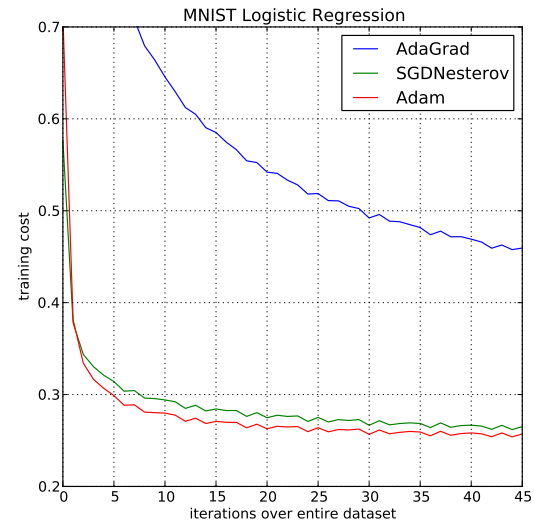

 - We can see that adagrad converges in a much slower rate than the other two optimizers. 

### Our Experiment Results

### Different weight Initialization

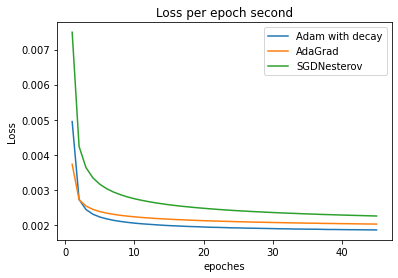

In [181]:
plt.plot(np.arange(1,epochs+1), loss_adam_decay, label='Adam with decay')
plt.plot(np.arange(1,epochs+1), loss_adagrad, label='AdaGrad')
plt.plot(np.arange(1,epochs+1), loss_sgdnst, label='SGDNesterov')
plt.legend()
plt.title("Loss per epoch second")
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.show()

In [173]:
print(f'adam with decay accuracy: {score(model_adam_decay, test_loader)}')
print(f'adagrad accuracy: {score(model_adagrad, test_loader)}')
print(f'sgd nesterov accuracy: {score(model_nesterov, test_loader)}')

<ipython-input-172-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-172-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float)


adam accuracy: 92.73
adagrad accuracy: 92.59
sgd nesterov accuracy: 92.15


 - All three models gained overall similar accuracy at the end of the training.
 - Both Adam and Adagrad yield better convergence than SGD with Nesterov.
 In contrast to the paper results where SGD was better than Adagrad.

### Same weight initialization

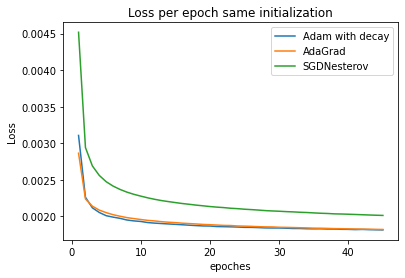

In [191]:
plt.plot(np.arange(1,epochs+1), loss_adam_decay_same, label='Adam with decay')
plt.plot(np.arange(1,epochs+1), loss_adagrad_same, label='AdaGrad')
plt.plot(np.arange(1,epochs+1), loss_sgdnst, label='SGDNesterov')
plt.legend()
plt.title("Loss per epoch same initialization")
plt.xlabel("epoches")
plt.ylabel("Loss")
plt.show()

In [193]:
print(f'adam with decay accuracy: {score(model_adam_decay_same_weights, test_loader)}')
print(f'adagrad accuracy: {score(model_adagrad_same_weights, test_loader)}')
print(f'sgd nesterov accuracy: {score(model_nesterov_same_weights, test_loader)}')

<ipython-input-172-4191b60fc3af>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
<ipython-input-172-4191b60fc3af>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float)


adam with decay accuracy: 92.78
adagrad accuracy: 92.78
sgd nesterov accuracy: 92.53


 - We can see similar results with the same weight initialization as with different.
 - Adam and AgaGrad seem to have smaller gap when they started with the same weights.
 - MNIST data with the logistic regression model might not have a very complicated loss function.
    This might cause the similarity between the two adaptive learning rate methods.